In [2]:
## todo: tune VMF parameters
## add translational jitter in 3D
## try other features on the mug
## try a feature like wrench handle
## correctly volumetrically scale the point cloud
    ## rescale based on pinhole camera depth model - should just be proportional

In [3]:
## add gaussian smoothing to error function?

In [ ]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
# import bayes3d.genjax
# import genjax
import pathlib
import numpy as np
import PIL
import cv2
import jax.image as jim

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=20.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
IDX = 13
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)


# bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
# rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('48', '1', bop_ycb_dir)
# table_pose = gt_poses[2,:,:]

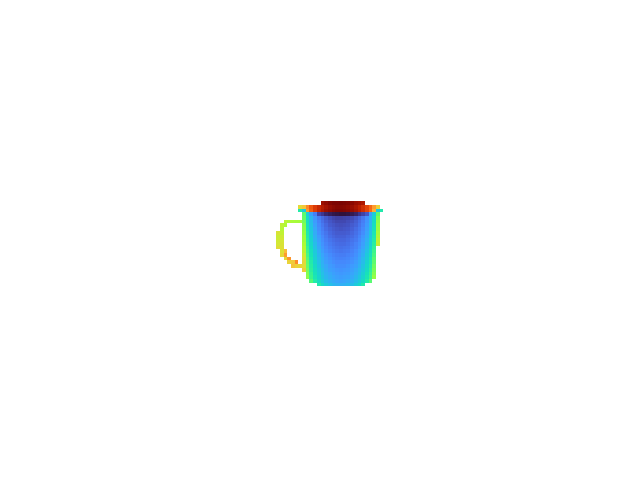

In [5]:
%matplotlib widget
img = b.RENDERER.render(table_pose[None,...], jnp.array([IDX]))
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = (37, 49) # old location based on table pose
#location = (55, 22) # location from YCB sample
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', marker="x", s=200)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [6]:
location

(37, 49)

In [7]:
coordinate = img[location[1],location[0],:3]
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]

num_test_feature_poses = 5000

# add translational jitters
# tune VMF parameters?
random_poses = jax.vmap(
    b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(
        jax.random.split(jax.random.PRNGKey(10),num_test_feature_poses), table_pose, 0.1, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

images = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([IDX]))
rendered_points = images[jnp.arange(images.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :]
distances = jnp.linalg.norm(rendered_points[...,:3]- coordinates[:,:3],axis=-1)
valid_indices = distances < 0.005
images_subset = images[valid_indices]
pixel_coordinates_subset = pixel_coordinates[valid_indices]


filter_size = 6
get_patch = lambda image, coordinate: jax.lax.dynamic_slice(image,
    (coordinate[1]-filter_size, coordinate[0]-filter_size, 0),
    (2*filter_size+1,2*filter_size+1,4))

patches = jax.vmap(get_patch)(images_subset, pixel_coordinates_subset)
template_depth = patches[:,filter_size,filter_size,2]

patches_centered = jnp.concatenate([patches[...,:3] - patches[:,filter_size,filter_size,:][...,None,None,:3],patches[...,3][...,None]],axis=-1)

valid_indices = jnp.abs(patches_centered[:,:,2]).sum(-1).sum(-1) > 1e-4
images_subset = images_subset[valid_indices]
pixel_coordinates_subset = pixel_coordinates_subset[valid_indices]
patches_centered = patches_centered[valid_indices]

In [8]:
b.utils.make_translation_grid_enumeration

<function bayes3d.utils.enumerations.make_translation_grid_enumeration(min_x, min_y, min_z, max_x, max_y, max_z, num_x=2, num_y=2, num_z=2)>

In [9]:
patches_centered.shape

(1386, 13, 13, 4)

In [10]:
b.utils.aabb(patches_centered[0,:,:,:3].reshape(-1,3))

(Array([ 3.6265445,  4.103901 , 19.412355 ], dtype=float32),
 Array([[1.       , 0.       , 0.       , 1.7895191],
        [0.       , 1.       , 0.       , 2.035162 ],
        [0.       , 0.       , 1.       , 9.666669 ],
        [0.       , 0.       , 0.       , 1.       ]], dtype=float32))

In [11]:
b.clear()
b.show_cloud('1',patches_centered[0,:,:,:3].reshape(-1,3))

In [12]:
b.show_cloud('2',scene_im[0,:,:,:3].reshape(-1,3),b.BLUE)
b.show_cloud('3',scene_im[0,21,55,:3].reshape(-1,3),b.RED)


NameError: name 'scene_im' is not defined

In [13]:
b.show_cloud('3',patches_centered[0,:,:,:3].reshape(-1,3) + scene_im[0,21,55,:3].reshape(-1,3),b.GREEN)

NameError: name 'scene_im' is not defined

In [14]:
# (55, 21): mug handle in scene 48, image 1

In [15]:
%matplotlib widget
img = scene_im[0]
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
#location = (37, 49) # old location based on table pose
location = (55, 22) # location from YCB sample
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', marker="x", s=200)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

NameError: name 'scene_im' is not defined

In [16]:
location

(37, 49)

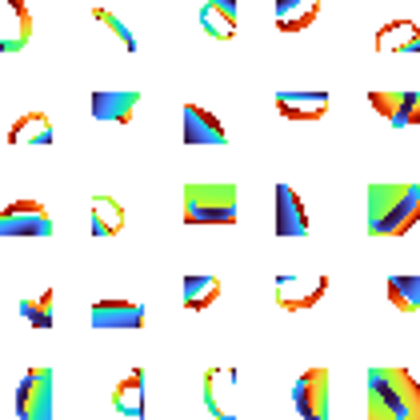

In [17]:
images = [b.get_depth_image(img[...,2]) for img in patches_centered[:25]]
b.viz.scale_image(b.hvstack_images(images, 5, 5),4.0)

In [18]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(1000),200), table_pose,  0.05, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([IDX]))
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), test_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

In [81]:
arr = jnp.array([1, 2, 3, 4])
jnp.append(arr,5)

Array([1, 2, 3, 4, 5], dtype=int32)

In [100]:
# img[50,50,2]/img_far[50,50,2]

def get_error_between_patches(slice, patch):

    # far_mask_slice_centered = (slice_centered[...,2] > 10.0)[...,None]
    # far_mask_patch = (patch[...,2] > 10.0)[...,None]

    slice_centered = jnp.concatenate([slice[...,:3] - slice[filter_size, filter_size,:3], slice[...,3][...,None]], axis=-1)
    patch_centered = jnp.concatenate([patch[...,:3] - patch[filter_size, filter_size,:3], patch[...,3][...,None]], axis=-1)
    slice_depth = slice[filter_size, filter_size,2]
    patch_depth = patch[filter_size, filter_size,2]

    scale_factor = patch_depth/slice_depth
    resize_shape = jnp.round(scale_factor*jnp.array([100,100]))
    resize_shape = jnp.append(resize_shape,3).astype(int)

    patch_centered = jim.resize(patch_centered, resize_shape,"bilinear")
    #patch_centered = cv2.resize(patch_centered, jnp.round(scale_factor*jnp.array([100,100])).astype(int))

    
    eps = 0.5
    far_mask_slice_centered =  ((1-slice_centered[...,3]) > eps)[...,None]
    far_mask_patch = ((1-patch_centered[...,3]) > eps)[...,None]

    
    slice_centered = slice_centered[...,:3]
    patch_centered = patch_centered[...,:3]
    
    slice_centered = slice_centered * (1.0 - far_mask_slice_centered) + 1000.0 * far_mask_slice_centered
    patch_centered = patch_centered * (1.0 - far_mask_patch) + 1000.0 * far_mask_patch
    
    norm_order = 2
    distances = jnp.linalg.norm(slice_centered - patch_centered, ord=norm_order, axis=-1)
    width = 0.005
    probabilities_per_pixel = -1*(distances > width/2)
        
    #probabilities_per_pixel = -jnp.power(distances,norm_order)/width
    return probabilities_per_pixel.sum()


get_error_between_patches_parallel_patches = jax.vmap(get_error_between_patches, in_axes=(None, 0))


@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_error(ij, observed_xyz_padded, patch):
    slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 4))
    # don't center slice, move patch to center pixel of slice instead?
    
    return get_error_between_patches(slice, patch)
    #return get_error_between_patches(slice, patch)


def get_errors(observed_xyz, template):
    observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    heatmap = compute_error(indices, observed_xyz_padded, template)
    return heatmap

    
get_errors_jit = jax.jit(get_errors)
get_errors_vmap_jit = jax.jit(jax.vmap(get_errors, in_axes=(None, 0)))

In [101]:
import matplotlib.colors as mcolors

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

# generate three side by side activation visualizations
# shape + activation, shape, and activation

def generate_heatmap_viz(observed_xyz, heatmaps):
    assert observed_xyz.shape[-1] == 4
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 3)
    
    original_image = observed_xyz[...,2]
    ax.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    #best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)
    best_idx = jnp.unravel_index(heatmaps.argmax(), heatmaps.shape)


    
    c_white = mcolors.colorConverter.to_rgba('white',alpha = 0)
    c_red= mcolors.colorConverter.to_rgba('red',alpha = 1)
    #cmap_rb = mcolors.LinearSegmentedColormap.from_list('rb_cmap',[c_red,c_white],512)
    cmap_rb = mcolors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_red],512)

    
    hmap = heatmaps[best_idx[0]]
    plot1 = ax.imshow(hmap, cmap_rb, alpha=0.75)
    ax.axis('off')

    print(best_idx)
    
    ax.scatter(best_idx[2], best_idx[1],color="black", marker='x', alpha=1) # plot the pose point 
    #ax.axis('off')
    
    ax2 = fig.add_subplot(1, 3, 1)
    ax2.axis('off')
    plot2 = ax2.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    ax3 = fig.add_subplot(1, 3, 2)
    ax3.axis('off')
    plot3 = ax3.imshow(hmap, cmap_rb)
    plt.colorbar(plot3,ax=ax3)
    
    img_PIL = fig2img(fig)
    return img_PIL

In [102]:
i = 34
observed_xyz = test_images[i]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)

#clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.min(heatmaps, axis=(1,2))[...,None,None]


#print(clean_heatmap.min())
print(clean_heatmap.max())
print(clean_heatmap.argmax())
print(clean_heatmap.min())
# visualize a single heatmap
generate_heatmap_viz(observed_xyz, clean_heatmap)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got Traced<ShapedArray(int32[3])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(int32[100,3])>with<BatchTrace(level=3/0)> with
    val = Traced<ShapedArray(int32[100,100,3])>with<BatchTrace(level=2/0)> with
      val = Traced<ShapedArray(int32[1386,100,100,3])>with<DynamicJaxprTrace(level=1/0)>
      batch_dim = 0
    batch_dim = 0
  batch_dim = 0.
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
This BatchTracer with object id 140211421192896 was created on line:
  /var/tmp/ipykernel_25229/2163273911.py:17 (get_error_between_patches)
This BatchTracer with object id 140207024753456 was created on line:
  /var/tmp/ipykernel_25229/2163273911.py:17 (get_error_between_patches)
This BatchTracer with object id 140207024751776 was created on line:
  /var/tmp/ipykernel_25229/2163273911.py:17 (get_error_between_patches)

(Array(0, dtype=int32), Array(46, dtype=int32), Array(33, dtype=int32))


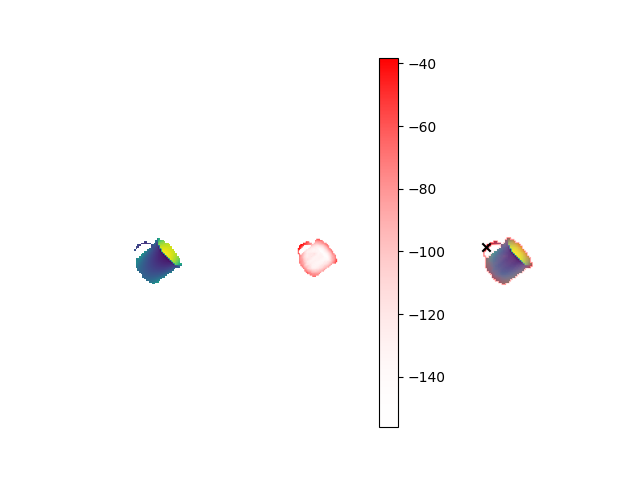

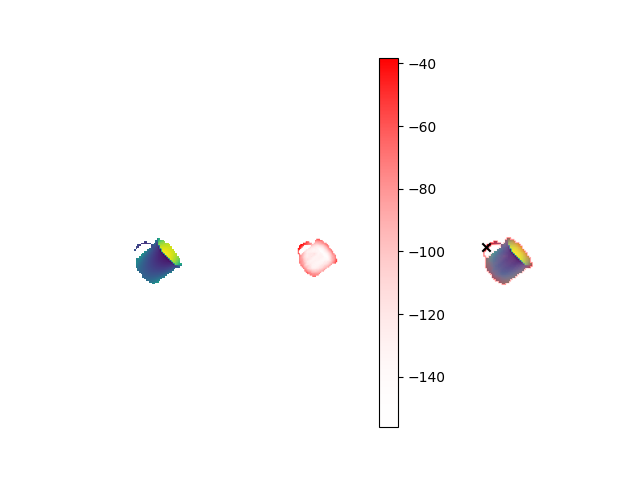

In [49]:
generate_heatmap_viz(observed_xyz, logsumexp(clean_heatmap,axis=0)[None,...])

In [26]:
# generate stack of heatmap images


In [50]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('48', '1', bop_ycb_dir)

In [51]:
gt_poses.shape

(5, 4, 4)

In [52]:
#scene_im = b.RENDERER.render_many(gt_poses[None,...],gt_ids)
scene_im = b.RENDERER.render_many(gt_poses[2,...][None,None,...],jnp.array([gt_ids[2]]))

In [53]:
gt_ids

Array([ 0,  5, 13, 18, 19], dtype=int32)

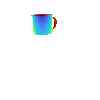

In [54]:
b.get_depth_image(scene_im[0,...,2])

-43
(Array(27, dtype=int32), Array(9, dtype=int32), Array(25, dtype=int32))


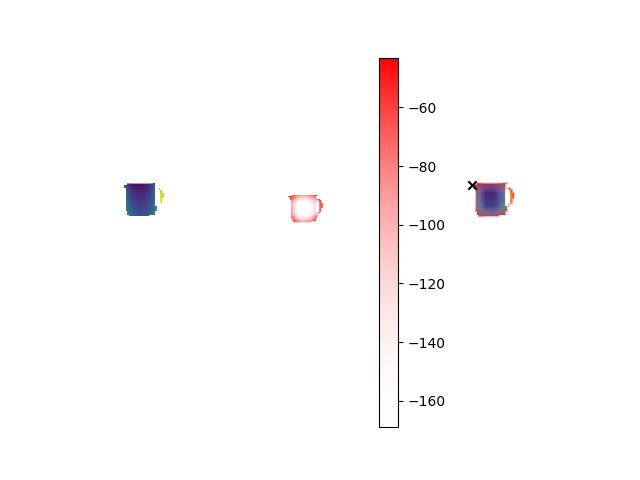

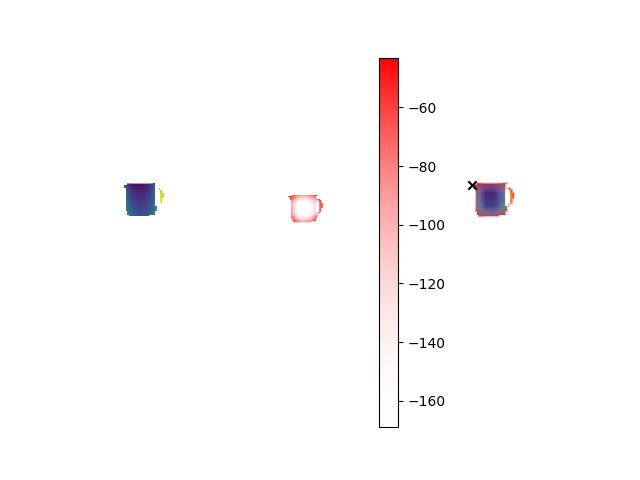

In [55]:
observed_xyz = scene_im[0]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
#clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.min(heatmaps, axis=(1,2))[...,None,None]

#print(clean_heatmap.min())
print(clean_heatmap.max())

# visualize a single heatmap
generate_heatmap_viz(observed_xyz, clean_heatmap)

(Array(0, dtype=int32), Array(9, dtype=int32), Array(25, dtype=int32))


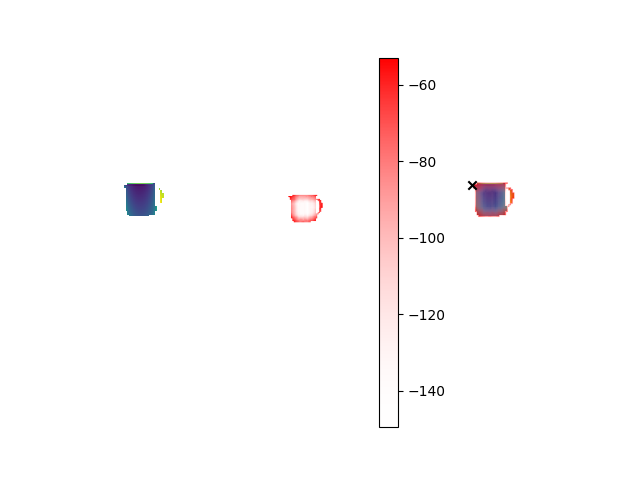

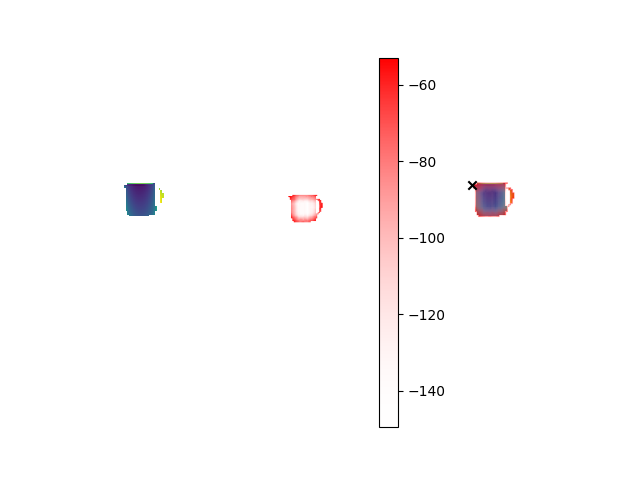

In [38]:
# marginal calculation over pose
generate_heatmap_viz(observed_xyz, logsumexp(clean_heatmap,axis=0)[None,...])

-169
(Array(0, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32))


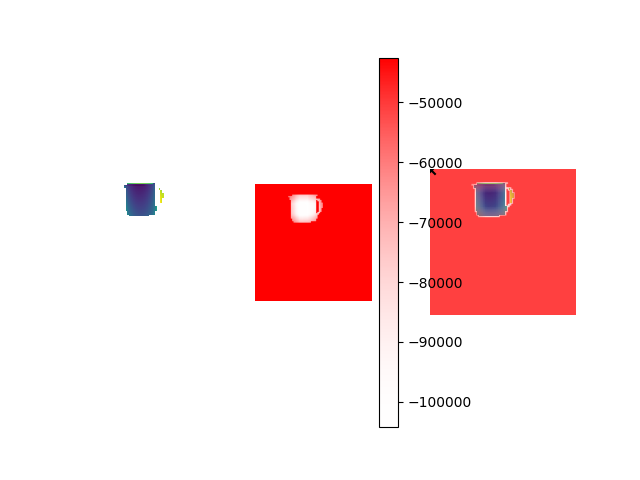

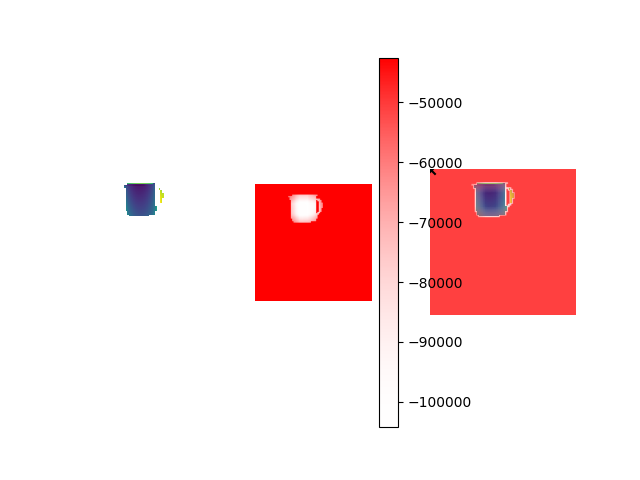

In [52]:
scene_im = b.RENDERER.render_many(gt_poses[2,:,:][None,None,...],jnp.array([gt_ids[2]]))

observed_xyz = scene_im[0]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
print(clean_heatmap.min())
# visualize a single heatmap
generate_heatmap_viz(observed_xyz, jnp.sum(clean_heatmap,axis=0)[None,...])

In [53]:
## more pose augmentations and translation jitter

(Array(162, dtype=int32), Array(0, dtype=int32), Array(0, dtype=int32))


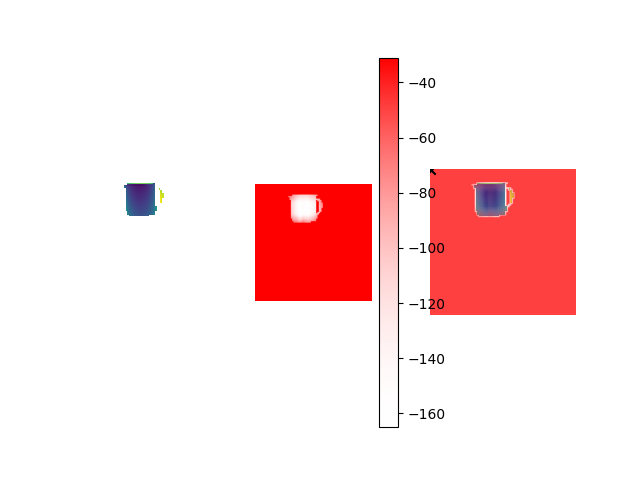

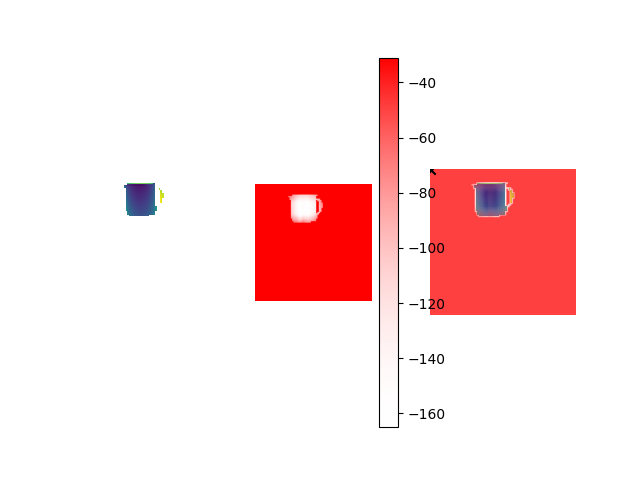

In [54]:
generate_heatmap_viz(observed_xyz, clean_heatmap)

-53
(Array(6, dtype=int32), Array(69, dtype=int32), Array(43, dtype=int32))


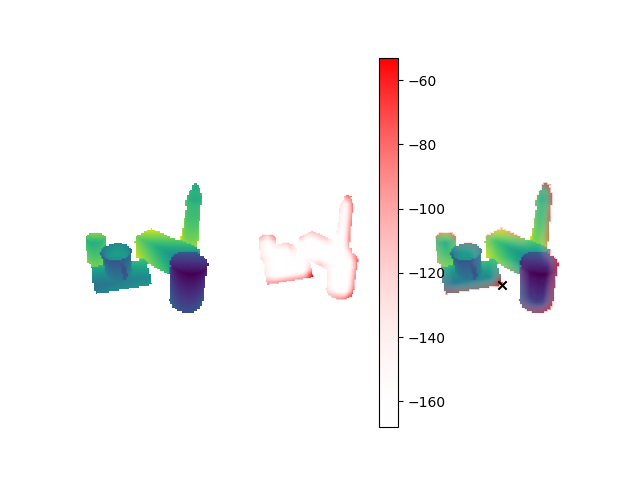

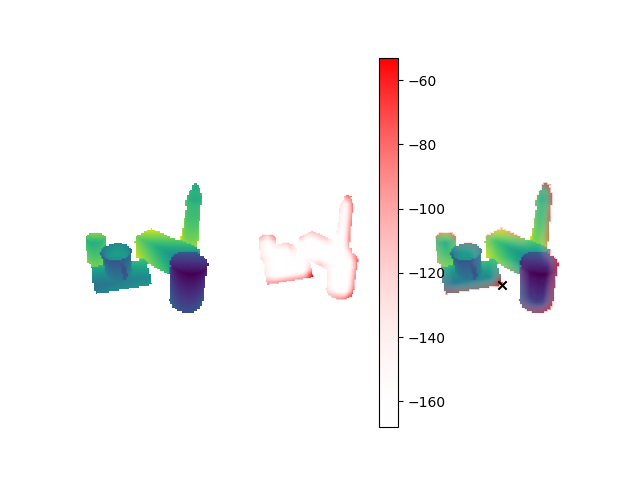

In [55]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('55', '22', bop_ycb_dir)

scene_im = b.RENDERER.render_many(gt_poses[None,...],gt_ids)

observed_xyz = scene_im[0]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
#clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
#print(clean_heatmap.min())

clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.min(heatmaps, axis=(1,2))[...,None,None]
print(clean_heatmap.max())


# visualize a single heatmap
generate_heatmap_viz(observed_xyz, clean_heatmap)

(Array(0, dtype=int32), Array(8, dtype=int32), Array(68, dtype=int32))


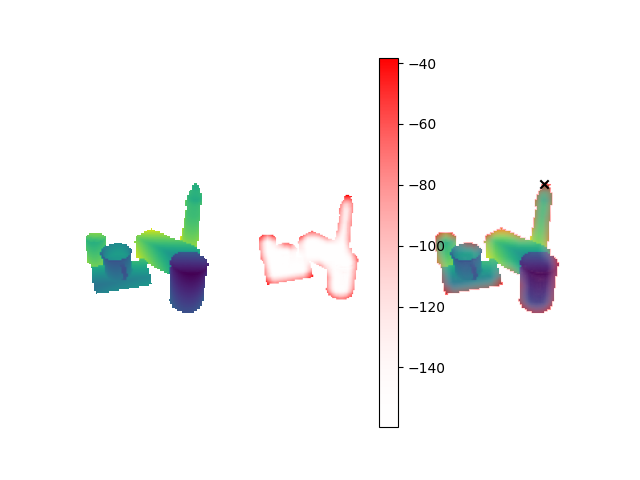

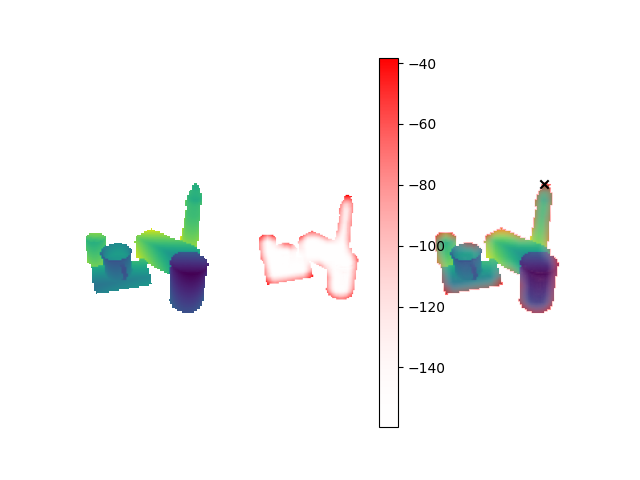

In [91]:
generate_heatmap_viz(observed_xyz, logsumexp(clean_heatmap,axis=0)[None,...])

In [92]:
clean_heatmap.shape

(5074, 88, 88)

In [25]:
gt_ids

Array([ 0,  2,  3, 11, 13, 15], dtype=int32)

In [26]:
gt_poses.shape

(6, 4, 4)

61


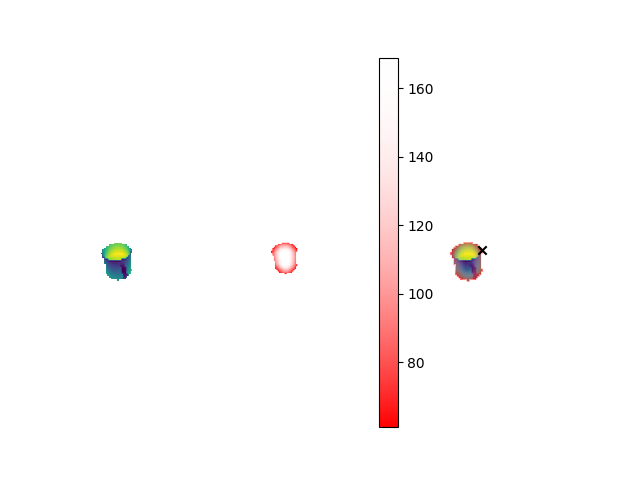

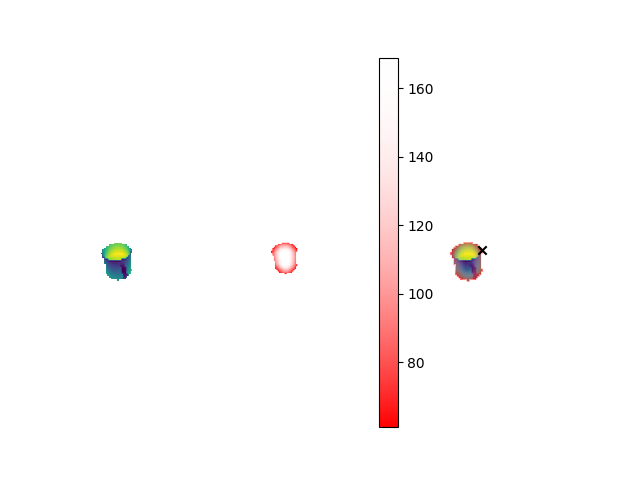

In [27]:
scene_im = b.RENDERER.render_many(gt_poses[-2,:,:][None,None,...],jnp.array([gt_ids[-2]]))

observed_xyz = scene_im[0]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
print(clean_heatmap.min())
# visualize a single heatmap
generate_heatmap_viz(observed_xyz, clean_heatmap)

In [28]:
# make heatmap gif from stack

def make_gif_from_pil_images(images, filename):
    """Save a list of PIL images as a GIF.
    
    Args:
        images (list): List of PIL images.
        filename (str): Filename to save GIF to.
    """
    images[0].save(
        fp=filename,
        format="GIF",
        append_images=images[1:],
        save_all=True,
        duration=500,
        loop=0,
    )


# filter size used to recover padding window
def make_heatmap_stack(test_images, patches_centered, filter_size):
    heatmap_list = []
    for observed_xyz in test_images:
        heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
        obs_mask = (observed_xyz[...,3][filter_size:-filter_size,filter_size:-filter_size]).astype(bool)
        clean_heatmap = (heatmaps*obs_mask) + (1-obs_mask)[None,...] * jnp.max(heatmaps, axis=(1,2))[...,None,None]
        heatmap_list.append(generate_heatmap_viz(observed_xyz, clean_heatmap))
    make_gif_from_pil_images(heatmap_list, 'heatmap_video_masked.gif')

